In [111]:
!nvidia-smi

Wed Feb  8 13:12:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.24       Driver Version: 528.24       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   60C    P8    N/A /  N/A |    361MiB /  2048MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [112]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:41:10_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [113]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12151677134713004603
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1297474971
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6695397469065531639
physical_device_desc: "device: 0, name: NVIDIA GeForce MX450, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [4]:
# Keras e TF

import tensorflow as tf 
from tensorflow import keras
# from tensorflow.keras.utils import load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, Conv1D, MaxPooling2D, Dense, Flatten, BatchNormalization, Activation, AveragePooling2D, Input, Flatten, Dropout
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras import regularizers
from tensorflow import initializers
from keras.layers import LSTM
# from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import TimeDistributed
from keras.layers import LSTM
from keras.models import load_model
from keras.layers import Activation

# Sk-Learn
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay

# Image management
import cv2

from time import time
import sys
import os
import glob2 as glob
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.linalg import fractional_matrix_power

from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.utils import class_weight 

import pydot
import pydotplus
from pydotplus import graphviz

In [5]:
# Set visualization size for figures 
plt.rcParams['figure.figsize'] = [7,7] # width, height

In [89]:
os.chdir('C:/Users/marco/Desktop/Local_Documents/data/COVIDx-splitted-resized-112')

Determiniamo il numero di immagini necessarie per bilanciare le classi, importando il .txt contenente il dettaglio delle immagini per ogni classe

In [118]:
# Import annotation (train, test)

os.chdir('C:/Users/marco/Desktop/Local_Documents/data/COVIDx-splitted-resized-112')

train_label =pd.read_csv('train_COVIDx9A.txt', sep = ' ', header=None)
train_label.columns=['patient id', 'img_path', 'label', 'data source']
train_label=train_label.drop(['patient id', 'data source'], axis=1 )

In [119]:
train_label.head()

img_path      label
0  pneumonia/SARS-10.1148rg.242035193-g04mr34g0-F...  pneumonia
1  pneumonia/SARS-10.1148rg.242035193-g04mr34g0-F...  pneumonia
2  pneumonia/SARS-10.1148rg.242035193-g04mr34g0-F...  pneumonia
3  pneumonia/SARS-10.1148rg.242035193-g04mr34g04a...  pneumonia
4  pneumonia/SARS-10.1148rg.242035193-g04mr34g04b...  pneumonia

In [120]:
train_label['label'].value_counts()

COVID-19     16490
normal        8085
pneumonia     5555
Name: label, dtype: int64

In [122]:
distr = train_label['label'].value_counts()
print(distr)

COVID-19     16490
normal        8085
pneumonia     5555
Name: label, dtype: int64


In [123]:
num_image_norm = distr[0] - distr[1] # Numero di immagini da generare per la classe normal
print(num_image_norm)

8405


In [124]:
num_image_pneum = distr[0] - distr[2] # Numero di immagini da generare per la classe pneumonia
print(num_image_pneum)

10935


# Oversampling via Augmentation

Tramite lo script *image_generator.py* andiamo a bilanciare le classi, generando  immagini ruotate, flippate, blurrate ecc.. dalle due classi minori, tali da avere un dataset bilanciato.

Andiamo a verificare l'effettivo bilanciamento del dataset

In [107]:
# Import annotation augmented (train, test)

os.chdir('C:/Users/marco/Desktop/Local_Documents/data/COVIDx-splitted-resized-112_augm')

train_label_augm =pd.read_csv('train_COVIDx9A_rebuild.txt', sep = ' ', header=None)
train_label_augm.columns=['img_path', 'label']

<AxesSubplot: xlabel='label', ylabel='Count'>

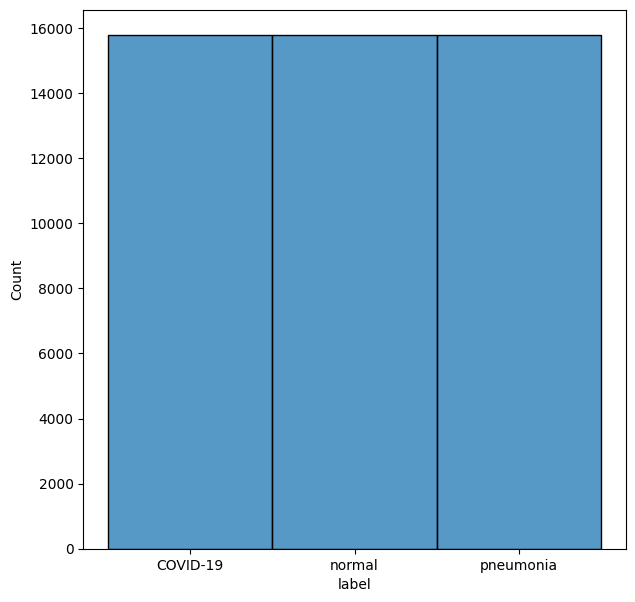

In [109]:
sns.histplot(train_label_augm['label'], discrete=True)

Il dataset ora contiene lo stesso numero di immagini per ogni classe

In [110]:
distr = train_label_augm['label'].value_counts()
print(distr)

COVID-19     15774
normal       15774
pneumonia    15774
Name: label, dtype: int64


# Image generator

Per bilanciare le classi viene usata la funzione menzionata precedentemente , che genera un numero fissato di immagini (un numero pari a bilanciare il dataset). Una volta generate le immaginisi avrà quindi un nuovo dataset di train, contenente le immagini vere e quelle fittizie. 

Per il training della CNN verrà usato questo approccio:
-   Per la fase di **training** viene usato il dataset contenuto in *COVIDx-splitted-resized-112_augm* (cartella che contiene immagini vere e fittizie appena generate)
-   Per la fase di **validation**  viene usato il dataset sbilanciato contenuto in *COVIDx-splitted-resized-112* contenente le sole immagini reali, affinchè in fase di validation del modello la distribuzione delle classi rispetti quella reale

In [114]:
batch_size = 32 # Batch size

os.chdir('C:/Users/marco/Desktop/Local_Documents/data/COVIDx-splitted-resized-112')

train_path = 'C:/Users/marco/Desktop/Local_Documents/data/COVIDx-splitted-resized-112_augm/train'
validation_path = 'C:/Users/marco/Desktop/Local_Documents/data/COVIDx-splitted-resized-112/train'
test_path = 'C:/Users/marco/Desktop/Local_Documents/data/COVIDx-splitted-resized-112_augm/test'

train_datagen = ImageDataGenerator(rescale=1./255., validation_split=0.3)
test_datagen = ImageDataGenerator(rescale=1./255.)

In [115]:
train_data = train_datagen.flow_from_directory(
        train_path,  
        target_size=(112, 112),  # Lo inserisco per precauzione
        batch_size=batch_size,
        seed=123,
        shuffle=True,
        subset='training',
        class_mode='categorical')

Found 33126 images belonging to 3 classes.


In [116]:
validation_data = train_datagen.flow_from_directory(
        validation_path,  
        target_size=(112, 112),  # Lo inserisco per precauzione
        batch_size=batch_size,
        seed=123,
        shuffle=True,
        subset='validation',
        class_mode='categorical')

Found 8820 images belonging to 3 classes.


In [ ]:
# Test set
test_data = test_datagen.flow_from_directory(
        test_path,  
        target_size=(112, 112),  # Lo inserisco per precauzione
        batch_size=batch_size,
        shuffle=False,
        class_mode='categorical')

Found 397 images belonging to 3 classes.


# Definizione dell'architettura

In [ ]:
#Definizione del CallBacks: Early stopper sulla loss di validazione
early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

In [ ]:
version = "v1"
img_size = '112'
checkpoint_filepath = f'C:/Users/marco/Desktop/Local_Documents/models/Class_Weight_NoAug/dcnn_model_{img_size}_{version}_val_acc_best.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
num_classes = 3
inputs = keras.Input((112,112,3))

x = inputs

x = keras.layers.Conv2D(16, 3, padding ="same", strides=1)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.Conv2D(32, 3,  padding ="same", strides=1)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(pool_size=(3,3), strides=(3,3))(x)
x = keras.layers.Dropout(0.2)(x)

x = keras.layers.Conv2D(64, 3,  padding ="same", strides=1)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.Conv2D(128, 2,  padding ="same", strides=1)(x)
x = keras.layers.Activation('relu')(x)

x = keras.layers.MaxPooling2D(pool_size=(2,2), strides=(3,3))(x)

x = keras.layers.Dropout(0.2)(x)

# x = keras.layers.GlobalMaxPool2D()(x)
x = keras.layers.Flatten()(x)

x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)

# x = keras.layers.Dense(512, activation='relu')(x)
# x = keras.layers.Dropout(0.5)(x)

# x = keras.layers.Dense(1000, activation='relu')(x)
# x = keras.layers.Dropout(0.5)(x)

outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
net_dcnn_112_cw = keras.Model(inputs, outputs)



In [ ]:
net_dcnn_112_cw.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 16)      448       
                                                                 
 activation_4 (Activation)   (None, 112, 112, 16)      0         
                                                                 
 batch_normalization_2 (Batc  (None, 112, 112, 16)     64        
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 activation_5 (Activation)   (None, 112, 112, 32)      0         
                                                           

In [ ]:
METRICS = [ 
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.TopKCategoricalAccuracy(name='top k accuracy'),
]
OPTIMIZER = keras.optimizers.Adam(learning_rate=0.0001)

In [ ]:
# batch size 
step_per_epoch_train = len(train_data.labels) // batch_size
print(step_per_epoch_train)
step_per_epoch_val = len(validation_data.labels) // batch_size
print(step_per_epoch_val)

735
183


In [ ]:
net_dcnn_112_cw.compile(loss=keras.losses.categorical_crossentropy,
            optimizer = OPTIMIZER,
            metrics=METRICS)

In [ ]:
history_dcnn_cw = net_dcnn_112_cw.fit(train_data,
          epochs=50,
          steps_per_epoch=step_per_epoch_train,
          validation_data=validation_data,
          validation_steps=step_per_epoch_val,
          class_weight = train_class_weights,
          workers = 3,
          callbacks=[model_checkpoint_callback, early_stopper])

In [ ]:
np.save(f'C:/Users/marco/Desktop/Local_Documents/models/Class_Weight_NoAug/dcnn_history_{img_size}_{version}.npy',
        history_dcnn_cw.history)

# Evaluation

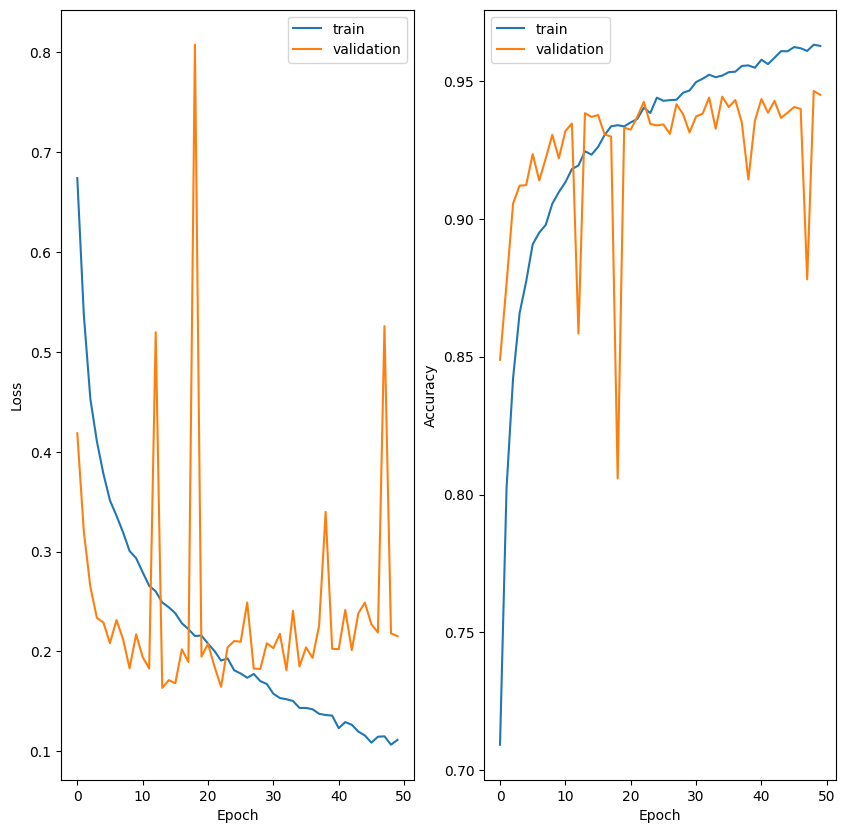

In [ ]:
# Visualization of the learning curves

# Loss
plt.subplot(1, 2, 1)
plt.plot(history_dcnn_cw.history['loss'])
plt.plot(history_dcnn_cw.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'])

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_dcnn_cw.history['accuracy'])
plt.plot(history_dcnn_cw.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'])

In [ ]:
# Evaluation
score = net_dcnn_112_cw.evaluate(test_data)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

13/13 [==============================] - 0s 24ms/step - loss: 0.3965 - accuracy: 0.9068 - precision: 0.9086 - recall: 0.9018 - auc: 0.9680 - top k accuracy: 1.0000
Test loss: 0.3964598774909973
Test accuracy: 0.9068009853363037


In [ ]:
pred = net_dcnn_112_cw.predict(test_data)

13/13 [==============================] - 4s 37ms/step


In [ ]:
test_data.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,

In [ ]:
print(pred.argmax(axis=1))

[0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 1 2 0 2 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 2 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 2 0 0 0 1 0 1 1 1 1 1 1 1 1 1 2 1 1 1 1 2 1 1 1 1 2 1
 2 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 0 2 0 2 2 2 2
 2 2 2 1 2 2 2 2 2 2 2 1 2 2 2 2 1 2 2 2 2 2 1 2 2 2 2 1 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [ ]:
test_data.class_indices

{'COVID-19': 0, 'normal': 1, 'pneumonia': 2}

In [ ]:
labels = test_data.class_indices
labels = list(labels.keys())
print(labels)

['COVID-19', 'normal', 'pneumonia']


In [ ]:
y_pred = pred.argmax(axis=1)
y_test = test_data.classes

# Matrice di confusione
matrix = confusion_matrix(y_test, y_pred, labels = [0,1,2])

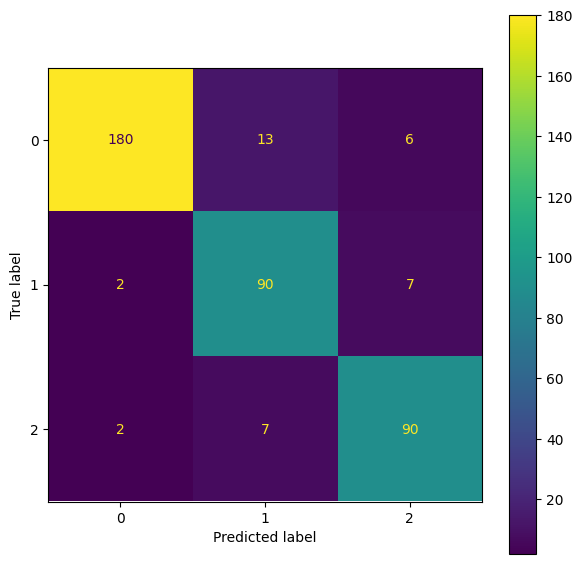

In [ ]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = matrix)

cm_display.plot()
plt.show()